In [2]:
import pandas as pd
import numpy as np
import math
from scipy.stats import zscore

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, precision_recall_curve, auc, accuracy_score
print('done')

done


### A Note to the Reviewer / Shortlisting Team

Hello 👋,

Thank you for taking the time to go through my work! 🙏  
After spending **48 hours** on this project, it reflects my strong dedication to solving real-world challenges using **Data Science**, especially in high-impact areas like **Fraud Detection**.

I've approached this not just as a technical task, but with a solid **Business Perspective**—carefully balancing **precision**, **recall**, and **practical deployment** needs.

📝 **Before or after reviewing this notebook**, I kindly request you to also check out my `data_overview.ipynb`.  
It captures the complete foundation and deep effort behind this work—everything from data exploration to feature engineering decisions.

If shortlisted, I promise to bring this same energy, curiosity, and commitment to your organization 🚀.  
Looking forward to the opportunity to contribute and grow together!

Warm regards,  
**Jayanta Nath**  
📍 *IIT Guwahati | BSc (Hons) in Data Science & AI*  
📧 *nathjayanta772@gmail.com*  
📱 *+91 9707885091*

## Loading the Dataset in Chunks for Efficient Processing

In [3]:
chunksize = 100_000
dfs = []

for chunk in pd.read_csv("C:/Users/HP/Downloads/Fraud.csv", chunksize=chunksize):
    dfs.append(chunk)

df = pd.concat(dfs)

### Overview of the datatset

In [4]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [5]:
# 8213/6354407 = 0.00129

In [6]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### Separating categorical and numerical columns

In [7]:
# Storing the categorical and numerical columns

cat_col = df.select_dtypes(include='object').columns
cat_col = [col for col in cat_col]
num_col = df.select_dtypes(exclude='object').columns
num_col = [num for num in num_col]

In [8]:
# Categorical column's unique value count

for col in cat_col:
    print(df[col].unique(), len(df[col].unique()))

['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN'] 5
['C1231006815' 'C1666544295' 'C1305486145' ... 'C1162922333' 'C1685995037'
 'C1280323807'] 6353307
['M1979787155' 'M2044282225' 'C553264065' ... 'C1850423904' 'C1881841831'
 'C2080388513'] 2722362


In [9]:
df2 = df.drop(['nameOrig', 'nameDest'], axis=1)
df2.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


## Outlier Detection and remove them

In [10]:
outliers = df2[(
        ((df2['oldbalanceOrg'] == 0) & (df2['amount'] > 0)) |
        (df2['newbalanceOrig'] == df2['oldbalanceOrg']) |
        ((df2['oldbalanceDest'] == 0) & (df2['newbalanceDest'] > 1e7))
    )]

In [11]:
print(outliers['isFraud'].value_counts())
outliers

isFraud
0    2103044
1         57
Name: count, dtype: int64


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
29,1,PAYMENT,9920.52,0.00,0.00,0.00,0.00,0,0
30,1,PAYMENT,3448.92,0.00,0.00,0.00,0.00,0,0
31,1,PAYMENT,4206.84,0.00,0.00,0.00,0.00,0,0
32,1,PAYMENT,5885.56,0.00,0.00,0.00,0.00,0,0
33,1,PAYMENT,5307.88,0.00,0.00,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...
6362461,730,CASH_OUT,0.00,0.00,0.00,1008609.53,1008609.53,1,0
6362462,730,TRANSFER,7316255.05,17316255.05,17316255.05,0.00,0.00,1,1
6362463,730,CASH_OUT,0.00,0.00,0.00,0.00,0.00,1,0
6362584,741,TRANSFER,5674547.89,5674547.89,5674547.89,0.00,0.00,1,1


In [12]:
# outlier remove
df3 =  df2[~(
            ((df['oldbalanceOrg'] == 0) & (df['amount'] > 0)) |
            (df['newbalanceOrig'] == df['oldbalanceOrg']) |
            ((df['oldbalanceDest'] == 0) & (df['newbalanceDest'] > 1e7))
        )]

In [14]:
df3.reset_index(drop=True)
df3.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


## Feature engineering

1. balanceDiffOrig = oldbalanceOrg - newbalanceOrg
2. balanceDiffDest = newbalanceDest - oldbalanceDest
3. errorOrig = oldbalanceOrg - amount - newbalanceOrg (from previous notebook we can say that data leakage was happened due to `errorOrig` column)

In [15]:
df3['balanceDiffOrig'] = df3['oldbalanceOrg'] - df3['newbalanceOrig']
df3['balanceDiffDest'] = df3['oldbalanceDest'] - df3['newbalanceDest']
#df2['errorOrig'] = df2['oldbalanceOrg'] - df2['amount'] - df2['newbalanceOrig'] skipping due to data leakage 

C:\Users\HP\AppData\Local\Temp\ipykernel_32352\4027891116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['balanceDiffOrig'] = df3['oldbalanceOrg'] - df3['newbalanceOrig']
C:\Users\HP\AppData\Local\Temp\ipykernel_32352\4027891116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['balanceDiffDest'] = df3['oldbalanceDest'] - df3['newbalanceDest']


In [16]:
df3.groupby('type')['isFraud'].value_counts()

type      isFraud
CASH_IN   0          1385784
CASH_OUT  0          1207614
          1             4079
DEBIT     0            35274
PAYMENT   0          1377250
TRANSFER  0           245441
          1             4077
Name: count, dtype: int64

Fraud mostly happening during `CASH_OUT (4116)` AND `TRANSFER (4097)`

### Fraud distributions among different types(Transfer, cash out etc)

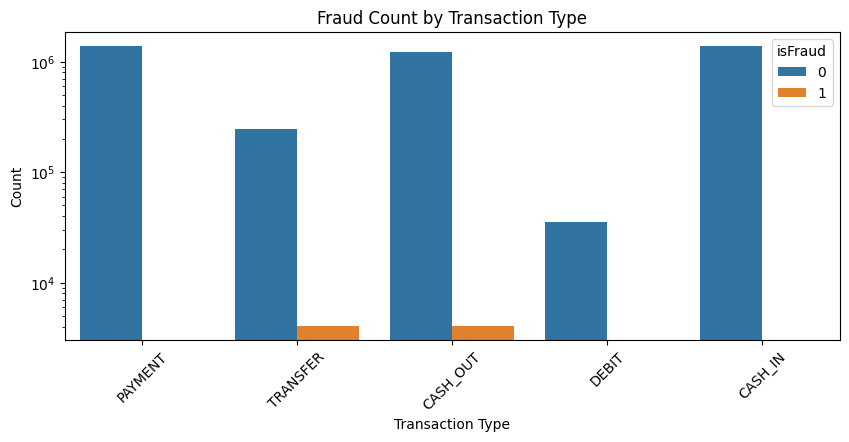

In [17]:
plt.figure(figsize=(10, 4))
sns.countplot(x='type', hue='isFraud', data=df3)
plt.yscale('log', base = 10)
plt.title('Fraud Count by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

So out of all `8213` fraud transactions, `8053` or `98%` happened when the newbalanceOrig == 0, meaning the sender’s account got completely drained.

In [18]:
dummies = pd.get_dummies(df3['type'])
df3 = pd.concat([df3, dummies], axis=1)
df3.reset_index(drop=True)
df3.shape

(4259519, 16)

In [19]:
df3

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0,9839.64,0.00,False,False,False,True,False
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0,1864.28,0.00,False,False,False,True,False
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0,181.00,0.00,False,False,False,False,True
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0,181.00,21182.00,False,True,False,False,False
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0,11668.14,0.00,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,0,339682.13,-339682.13,False,True,False,False,False
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,0,6311409.28,0.00,False,False,False,False,True
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,6311409.28,-6311409.27,False,True,False,False,False
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,0,850002.52,0.00,False,False,False,False,True


In [20]:
df4 = df3.drop(['type'], axis=1)

In [21]:
df4 = df4.reset_index(drop=True)
print(df4['isFraud'].value_counts())
df4.sample(5)

isFraud
0    4251363
1       8156
Name: count, dtype: int64


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
259474,17,19838.62,2085446.77,2105285.39,2460131.37,2539885.27,0,0,-19838.62,-79753.90,True,False,False,False,False
149780,14,268024.76,32934.00,0.00,0.00,268024.76,0,0,32934.00,-268024.76,False,True,False,False,False
1883926,225,67555.66,7632566.42,7700122.07,625069.71,557514.05,0,0,-67555.65,67555.66,True,False,False,False,False
1910524,227,281554.07,19908.00,0.00,1857101.33,2138655.40,0,0,19908.00,-281554.07,False,True,False,False,False
3345695,353,14934.54,2052720.55,2067655.09,170492.69,155558.16,0,0,-14934.54,14934.53,True,False,False,False,False


### Correlation Heatmap before Cleaning

<Axes: >

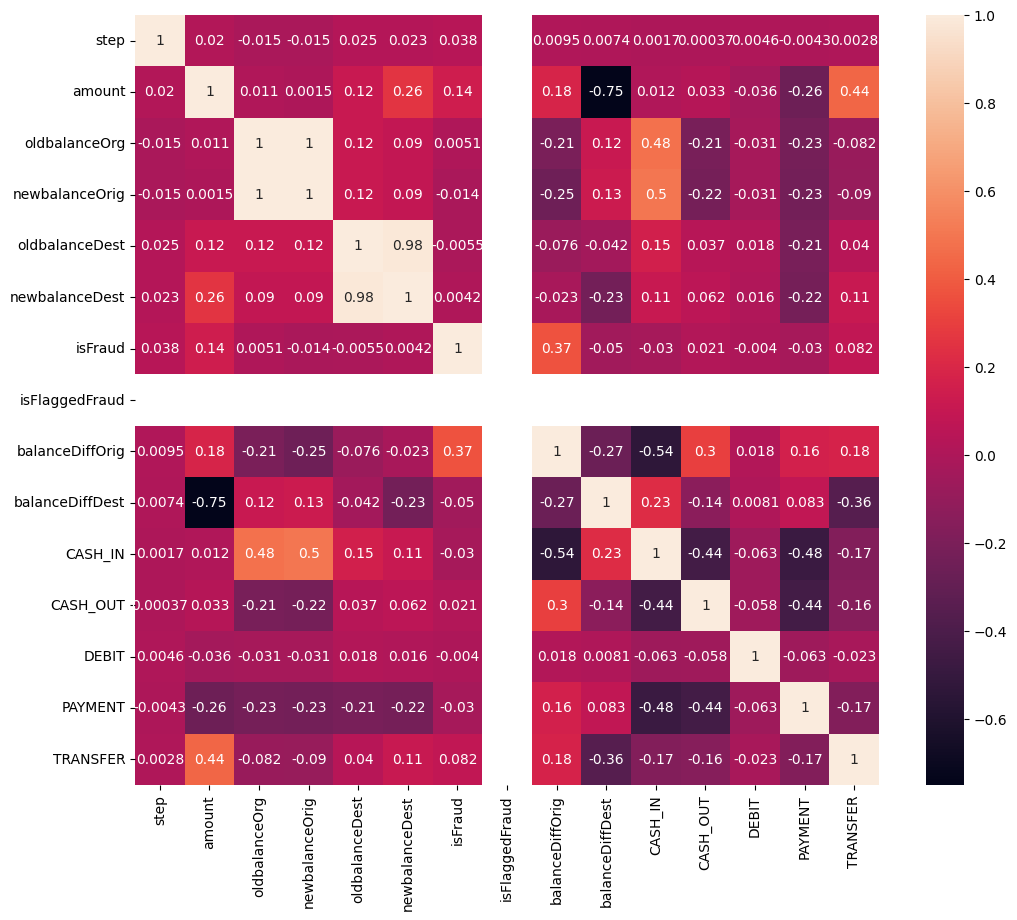

In [22]:
corr = df4.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True)

In [23]:
df5 = df4.drop(['step', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud'], axis=1)

### Correlation Heatmap after Cleaning

<Axes: >

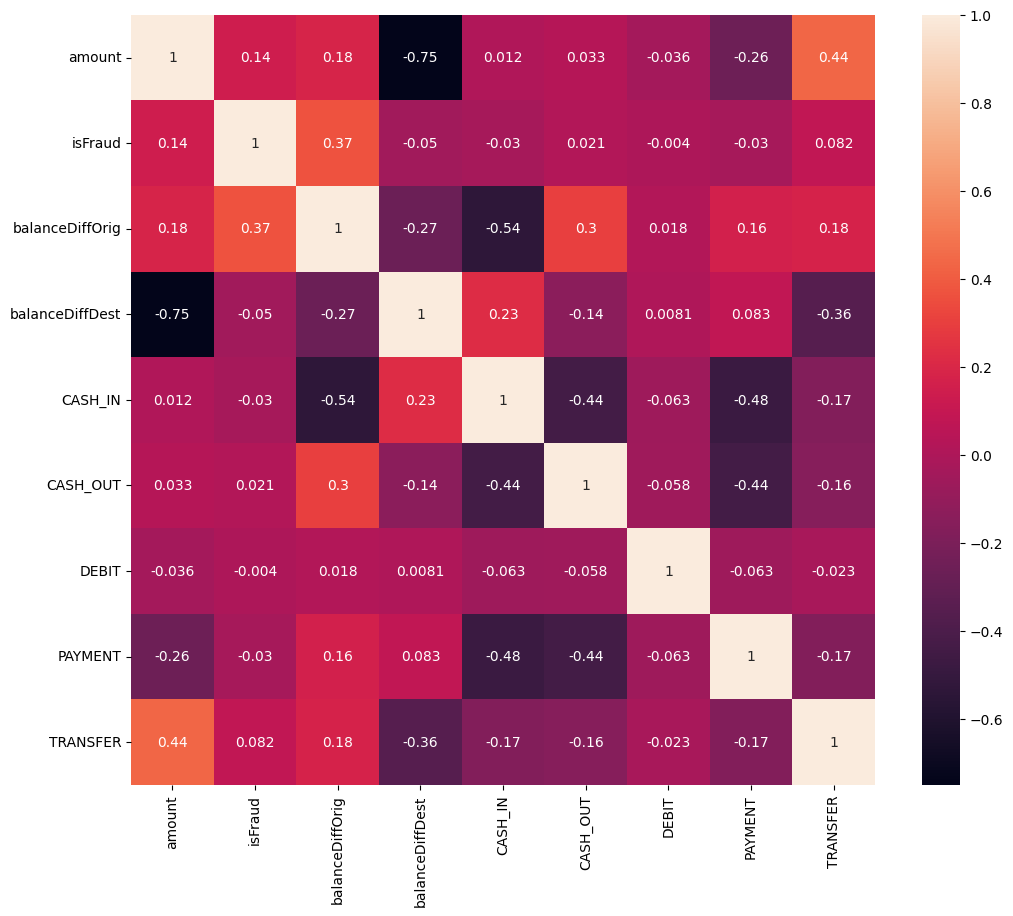

In [24]:
corr = df5.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True)

In [25]:
print(df5['isFraud'].value_counts())

isFraud
0    4251363
1       8156
Name: count, dtype: int64


### Downsampling Majority Class to Balance the Dataset

In [26]:
from sklearn.utils import resample

# Separate majority and minority
df_majority = df5[df5.isFraud == 0]
df_minority = df5[df5.isFraud == 1]

# Downsample majority class
df_majority_downsampled = resample(
    df_majority, 
    replace=False, 
    n_samples=8156,  # 8156/16312/24468/81560
    random_state=42
)

# Combine
df_balanced = pd.concat([df_majority_downsampled, df_minority], axis=0)

In [27]:
df_balanced.reset_index(drop=True, inplace=True)
df_balanced.head()

,amount,isFraud,balanceDiffOrig,balanceDiffDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,498385.90,0,103867.00,-498385.90,False,False,False,False,True
1,113961.34,0,-113961.35,113961.34,True,False,False,False,False
2,12766.05,0,12766.05,0.00,False,False,False,True,False
3,326760.21,0,-326760.21,-181429.36,True,False,False,False,False
4,16294.33,0,10940.00,0.00,False,False,False,True,False


### Scalling Input(x) using Standard Scalar

In [28]:
df_type = df_balanced[['CASH_IN','CASH_OUT','DEBIT','PAYMENT','TRANSFER','isFraud']]
from sklearn.preprocessing import  StandardScaler
sc = StandardScaler()
scaled = sc.fit_transform(df_balanced[['amount','balanceDiffOrig','balanceDiffDest']])
scaled_df = pd.DataFrame(scaled, columns=['amount', 'balanceDiffOrig', 'balanceDiffDest'])
df_final = pd.concat([scaled_df, df_type], axis=1)
df_final

,amount,balanceDiffOrig,balanceDiffDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud
0,-0.173381,-0.330027,-0.063831,False,False,False,False,True,0
1,-0.382611,-0.447236,0.365680,True,False,False,False,False,0
2,-0.437689,-0.379047,0.285745,False,False,False,True,False,0
3,-0.266791,-0.561739,0.158488,True,False,False,False,False,0
4,-0.435768,-0.380030,0.285745,False,False,False,True,False,0
...,...,...,...,...,...,...,...,...,...
16307,-0.259758,-0.203140,0.047487,False,True,False,False,False,1
16308,2.990470,3.010122,0.285745,False,False,False,False,True,1
16309,2.990470,3.010122,-4.141181,False,True,False,False,False,1
16310,0.017994,0.071453,0.285745,False,False,False,False,True,1


In [29]:
X = df_final.drop('isFraud', axis=1)
y = df_final['isFraud']
X.shape, y.shape

((16312, 8), (16312,))

### Train test splitting

In [30]:
# Now split this 1M into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

# Quick sanity check
print(f"Train size X: {X_train.shape}, Test size X: {X_test.shape}")
print(f"Train frauds y: {y_train.shape}, Test frauds y: {y_test.shape}")

Train size X: (10929, 8), Test size X: (5383, 8)
Train frauds y: (10929,), Test frauds y: (5383,)


In [31]:
print(y_train.value_counts())
print(y_test.value_counts())

isFraud
1    5465
0    5464
Name: count, dtype: int64
isFraud
0    2692
1    2691
Name: count, dtype: int64


### Model comparision with F1/Recall/Precision

#### *Summary of Bad, Good, and Excellent Models*

| **Model Type**        | **Recall**        | **FN %**              | **Fraud Detected (TP)** | **Fraud Missed (FN)** |
|-----------------------|-------------------|------------------------|-------------------------|-----------------------|
| **Bad Model**         | Below 60%         | More than 40%          | Less than **4,928**      | More than **3,285**    |
| **Good Model**        | 60% to 80%        | 20% to 40%             | **4,928 – 6,570**        | **1,643 – 3,285**      |
| **Excellent Model**   | 80% to 95%        | 5% to 20%              | **6,570 – 7,802**        | **411 – 1,643**        |
| **Outstanding Model** | Above 95%         | Less than 5%           | More than **7,802**      | Less than **411**      |

### Model Performance calculator

In [32]:
def model_performance(model):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate metrics for class 1 (fraud)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_proba)

    print(f"Recall (Fraud):     {round(recall*100, 2)}%")
    print(f"Precision (Fraud):  {round(precision*100, 2)}%%")
    print(f"F1 Score:           {round(f1*100, 2)}%")
    print(f"AUC-ROC Score:      {round(auc_roc*100, 2)}%")

In [33]:
def classification_report_detailed(model):
    y_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, y_pred)

    print(f"Training accuracy of Voting Classifier is : {train_acc}")
    print(f"Test accuracy of Voting Classifier is : {test_acc}")

    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [56]:
def precision_recall_auc_curve(model):  # Plot 1: Precision-Recall Curve
    y_scores = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)

    # Create subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Precision-Recall Curve
    axes[0].plot(recall, precision, color='b')
    axes[0].set_xlabel('Recall')
    axes[0].set_ylabel('Precision')
    axes[0].set_title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')

    # Plot 2: Precision vs Recall vs Threshold
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
    axes[1].plot(thresholds, precisions[:-1], label='Precision')
    axes[1].plot(thresholds, recalls[:-1], label='Recall')
    axes[1].set_xlabel('Threshold')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_title('Precision vs Recall vs Threshold')

    # Show the plots
    plt.tight_layout()
    plt.show()

## SMOTE Resampling

In [57]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

## Model training and classification reports

In [58]:
# Compute scale_pos_weight for imbalanced classes
scale_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
scale_weight

np.float64(1.0)

### 1. XGBClassifier Model

In [36]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=8,
)

xgb.fit(X_train, y_train)
print('Model score:',xgb.score(X_test, y_test))
cm = confusion_matrix(y_test, xgb.predict(X_test))
classification_report_detailed(xgb)

Model score: 0.9656325469069292
Training accuracy of Voting Classifier is : 0.9717291857273559
Test accuracy of Voting Classifier is : 0.9656325469069292
[[2526  166]
 [  19 2672]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      2692
           1       0.94      0.99      0.97      2691

    accuracy                           0.97      5383
   macro avg       0.97      0.97      0.97      5383
weighted avg       0.97      0.97      0.97      5383



In [59]:
X_test.head()

,amount,balanceDiffOrig,balanceDiffDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
14254,-0.022119,0.031797,0.285745,False,False,False,False,True
8837,0.299565,0.349821,-0.673330,False,True,False,False,False
11785,-0.204138,-0.148153,-0.024192,False,True,False,False,False
1389,-0.430292,-0.385390,0.267259,False,True,False,False,False
8273,-0.443494,-0.384786,0.284272,False,True,False,False,False


In [60]:
y_test

14254    1
8837     1
11785    1
1389     0
8273     1
        ..
10518    1
935      0
9131     1
13755    1
10644    1
Name: isFraud, Length: 5383, dtype: int64

In [61]:
xgb.predict([[-0.43029183, -0.38538989,  0.26725852, 0, 1,
        0, 0 , 0]])

array([0])

In [62]:
import pickle
# Save the model to a .pkl file
'''with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb, file)'''

"with open('xgb_model.pkl', 'wb') as file:\n    pickle.dump(xgb, file)"

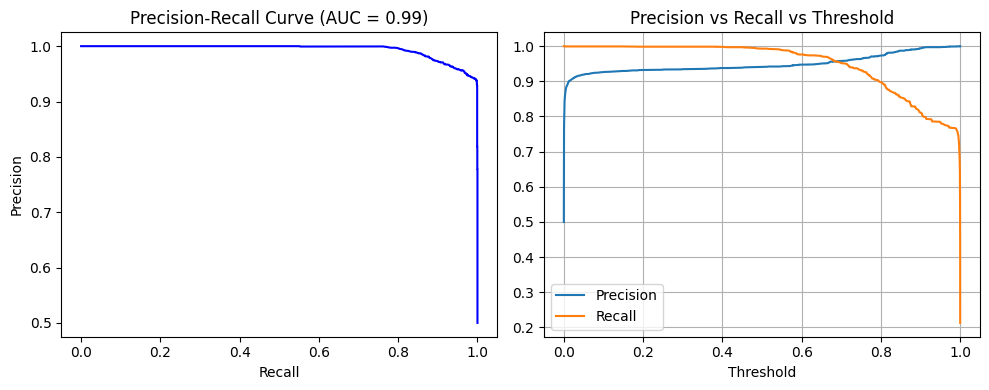

In [63]:
precision_recall_auc_curve(xgb)

#### XGBoost Model - Performance Comparison
*For example, here (1:1) means (fraud:non_fraud)*

| Metric               | SMOTE (1:1) No Resampling | SMOTE (1:1) With Resampling | SMOTE (1:2) No Resampling | SMOTE (1:2) With Resampling | SMOTE (1:3) No Resampling | SMOTE (1:3) With Resampling | SMOTE (1:10) No Resampling | SMOTE (1:10) With Resampling |
|----------------------|---------------------------|-----------------------------|---------------------------|-----------------------------|---------------------------|-----------------------------|----------------------------|------------------------------|
| **Recall (Fraud)**      | 97.21%                    | 97.36%                      | 95.1%                     | 96.4%                       | 94.69%                    | 97.06%                      | 90.64%                     | 95.88%                       |
| **Precision (Fraud)**   | 96.46%                    | 96.54%                      | 96.49%                    | 94.33%                      | 95.97%                    | 92.07%                      | 96.71%                     | 81.21%                       |
| **F1 Score**            | 96.84%                    | 96.95%                      | 95.79%                    | 95.35%                      | 95.32%                    | 94.5%                       | 93.58%                     | 87.94%                       |
| **AUC**                 | 99.7%                     | 99.7%                       | 99.75%                    | 99.73%                      | 99.74%                    | 99.74%                      | 99.77%                     | 99.76%                       |


### 2. Random Forest Classifier model

In [51]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=8, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
print('Model score:',rf_model.score(X_test, y_test))
cm = confusion_matrix(y_test, rf_model.predict(X_test))
classification_report_detailed(rf_model)
#model_performance(rf_model)

Model score: 0.9637748467397362
Training accuracy of Voting Classifier is : 0.9677035681610247
Test accuracy of Voting Classifier is : 0.9637748467397362
[[2507  185]
 [  10 2681]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      2692
           1       0.94      1.00      0.96      2691

    accuracy                           0.96      5383
   macro avg       0.97      0.96      0.96      5383
weighted avg       0.97      0.96      0.96      5383



In [52]:
import pickle
# Save the model to a .pkl file
'''with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)'''

"with open('rf_model.pkl', 'wb') as file:\n    pickle.dump(rf_model, file)"

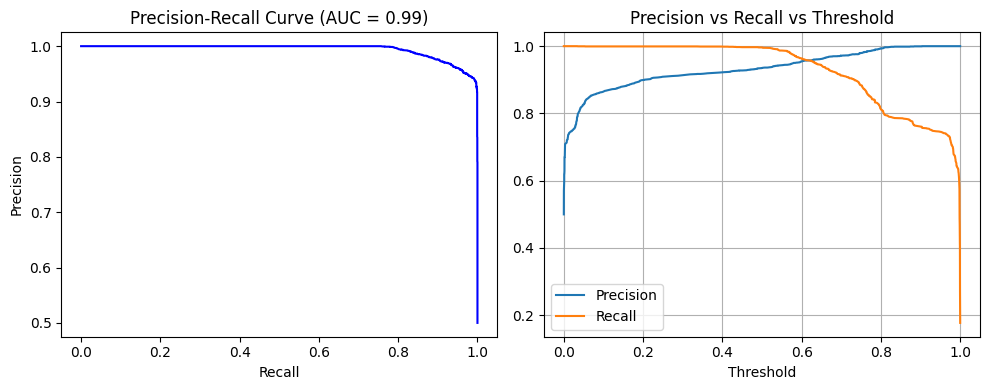

In [64]:
precision_recall_auc_curve(rf_model)

#### Random Forest Model - Performance Comparison  
*For example, here (1:1) means (fraud:non_fraud) ratio*

| Metric               | SMOTE (1:1) No Resample | SMOTE (1:1) Resample | SMOTE (1:2) No Resample | SMOTE (1:2) Resample | SMOTE (1:3) No Resample | SMOTE (1:3) Resample | SMOTE (1:10) Resample | SMOTE (1:10) No Resample |
|----------------------|-------------------------|-----------------------|-------------------------|-----------------------|-------------------------|-----------------------|------------------------|--------------------------|
| **Recall (Fraud)**   | 98.25%                  | 98.18%                | 97.33%                  | 97.55%                | 97.06%                  | 97.32%                | 95.13%                 | 96.21%                   |
| **Precision (Fraud)**| 95.45%                  | 95.38%                | 92.09%                  | 91.02%                | 87.98%                  | 87.24%                | 53.94%                 | 72.43%                   |
| **F1 Score**         | 96.83%                  | 96.76%                | 94.64%                  | 94.17%                | 92.3%                   | 92.01%                | 69.93%                 | 82.64%                   |
| **AUC**              | 99.64%                  | 99.64%                | 99.62%                  | 99.59%                | 99.59%                  | 99.58%                | 99.2%                  | 99.61%                   |


From my perspective, SMOTE (1:1) No Resample is the best choice for real-world fraud detection. It consistently excels in recall, precision, F1 score, and AUC, making it ideal for minimizing both false positives and false negatives in fraud detection.

### 3. Decision Tree Classifier Model

In [75]:
dt_model = DecisionTreeClassifier(max_depth=5, class_weight={0: 1, 1: 10}) # {0: 1, 1: 10} : performing very well well than 'balanced'
dt_model.fit(X_train, y_train)
print('Model score:',dt_model.score(X_test, y_test))
cm = confusion_matrix(y_test, dt_model.predict(X_test))
classification_report_detailed(dt_model)

Model score: 0.9498420954857886
Training accuracy of Voting Classifier is : 0.9523330283623056
Test accuracy of Voting Classifier is : 0.9498420954857886
[[2426  266]
 [   4 2687]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      2692
           1       0.91      1.00      0.95      2691

    accuracy                           0.95      5383
   macro avg       0.95      0.95      0.95      5383
weighted avg       0.95      0.95      0.95      5383



In [76]:
import pickle
# Save the model to a .pkl file
'''with open('dt_model.pkl', 'wb') as file:
    pickle.dump(dt_model, file)'''

"with open('dt_model.pkl', 'wb') as file:\n    pickle.dump(dt_model, file)"

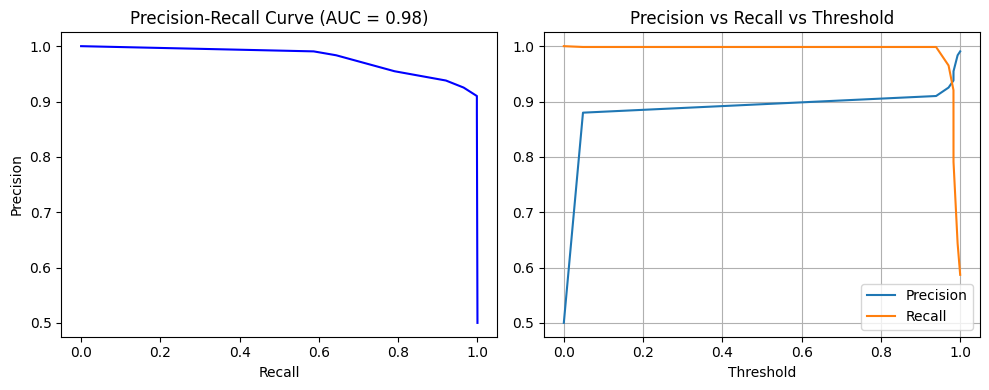

In [77]:
precision_recall_auc_curve(dt_model)

#### Decision Tree Model - Performance Comparison
*For example, here (1:1) means (fraud:non_fraud) ratio*

| Metric               | SMOTE (1:1) No Resample | SMOTE (1:1) Resample | SMOTE (1:2) No Resample | SMOTE (1:2) Resample | SMOTE (1:3) No Resample | SMOTE (1:3) Resample | SMOTE (1:10) Resample | SMOTE (1:10) No Resample |
|----------------------|-------------------------|-----------------------|-------------------------|-----------------------|-------------------------|-----------------------|------------------------|--------------------------|
| **Recall (Fraud)**      | 99.29%                  | 99.29%                | 99.18%                  | 99.0%                 | 98.77%                  | 99.0%                 | 99.41%                 | 95.13%                   |
| **Precision (Fraud)**   | 92.84%                  | 92.81%                | 87.31%                  | 84.28%                | 80.79%                  | 80.41%                | 53.94%                 | 71.86%                   |
| **F1 Score**            | 95.96%                  | 95.94%                | 92.87%                  | 91.05%                | 88.88%                  | 88.74%                | 69.93%                 | 81.87%                   |
| **AUC**                 | 99.01%                  | 99.0%                 | 99.09%                  | 99.04%                | 98.98%                  | 99.01%                | 99.2%                  | 98.73%                   |

### 4. Logistic Regression Model

The below model's performance is relatively low campared to others.

In [85]:
lr_model = LogisticRegression(C=10, solver = 'liblinear', class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train)
print('Model score:',lr_model.score(X_train, y_train))
cm = confusion_matrix(y_test, lr_model.predict(X_test))
classification_report_detailed(lr_model)

Model score: 0.958188472095151
Training accuracy of Voting Classifier is : 0.958188472095151
Test accuracy of Voting Classifier is : 0.9533717258034553
[[2450  242]
 [   9 2682]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2692
           1       0.92      1.00      0.96      2691

    accuracy                           0.95      5383
   macro avg       0.96      0.95      0.95      5383
weighted avg       0.96      0.95      0.95      5383



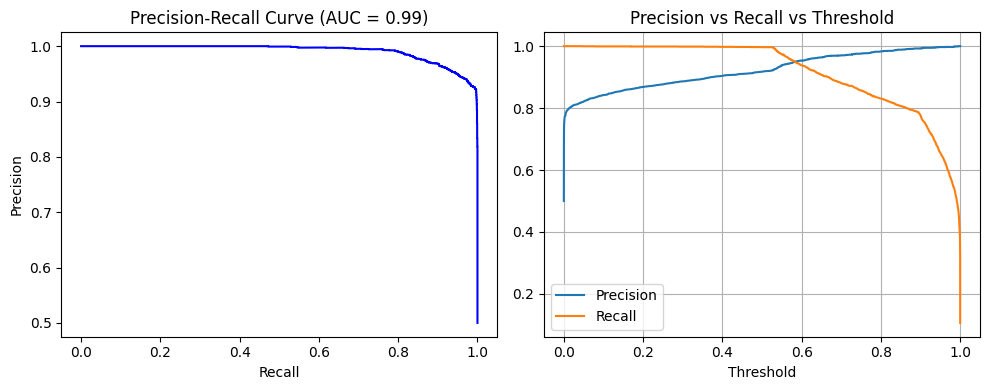

In [86]:
precision_recall_auc_curve(lr_model)